<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/dll_hw_8_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 8 | Attention

## Иванов Денис

Решить задачу перевода с помощью механизме внимания

Возьмите англо-русскую пару фраз (www.manythings.org....org/anki/)

Обучите на них seq2seq with attention

a. На основе скалярного произведения

b. На основе MLP

Оцените качество

### 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import random
import re
import string
from   itertools import product
import unicodedata

import torch
import torch.nn as nn
from   torch import optim
import torch.nn.functional as F

import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
plt.switch_backend('agg')

In [3]:
from io import open
import os
import sys
from google.colab import drive 

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Импорт и предобработка текста

In [ ]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2021-09-27 07:04:38--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14385451 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  13.72M  --.-KB/s    in 0.09s   

2021-09-27 07:04:39 (147 MB/s) - ‘rus-eng.zip’ saved [14385451/14385451]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
!tail rus.txt

The more countries a language is spoken in, the less important it is to sound like a native speaker, since speakers of that language are accustomed to hearing various dialects.	Чем в большем количестве стран используется тот или иной язык, тем менее важно иметь такое же произношение, как у его носителей, так как носители этого языка привыкли к звучанию различных акцентов.	CC-BY 2.0 (France) Attribution: tatoeba.org #954354 (CK) & #4465953 (Wezel)
A mistake young people often make is to start learning too many languages at the same time, as they underestimate the difficulties and overestimate their own ability to learn them.	Ошибка, которую часто делают молодые, — начинают учить слишком много языков одновременно: они недооценивают трудности и переоценивают свои способности к изучению.	CC-BY 2.0 (France) Attribution: tatoeba.org #2783162 (catcher) & #5118905 (Wezel)
We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice sy

In [ ]:
SOS_token = 0
EOS_token = 1
lang1 = 'eng'
lang2 = 'rus'

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('rus.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    for p in pairs:
        del p[2]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, prefi, max_): ##############
    if prefi == None:
        return  len(p[0].split(' ')) >3 and \
                len(p[1].split(' ')) >3 and \
                len(p[0].split(' ')) < max_ and \
                len(p[1].split(' ')) < max_ 
    else:
        return  len(p[0].split(' ')) >3 and \
                len(p[1].split(' ')) >3 and \
                len(p[0].split(' ')) < max_ and \
                len(p[1].split(' ')) < max_ and \
                p[1].startswith(eng_prefixes)

def filterPairs(pairs, pref, max_l):
    return [pair for pair in pairs if filterPair(pair, pref, max_l)]

In [ ]:
def prepareData(lang1, lang2, pre, max_le,  reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, pre, max_le)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', None, 20, True)
print(random.choice(pairs))

Reading lines...
Read 431097 sentence pairs
Trimmed to 409735 sentence pairs
Counting words...
Counted words:
rus 52630
eng 15912
['занятия в школе начинаются в девять а заканчиваются в шесть .', 'school begins at nine and is over at six .']


In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair, input_l, output_l):
    input_tensor = tensorFromSentence(input_l, pair[0])
    target_tensor = tensorFromSentence(output_l, pair[1])
    return (input_tensor, target_tensor)

### 3. Архитектура сети

#### 3.1. Encoder




In [ ]:
class EncoderRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type):
        super(EncoderRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.embedding   = nn.Embedding(input_size, hidden_size)
        self.rnn         = rnn_type(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded         = self.embedding(input).view(1, 1, -1)
        output           = embedded
        output, hidden   = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 3.2. Decoder - 1

In [ ]:
class AttnDecoderRNN_mlp(nn.Module): 
    def __init__(self, hidden_size, output_size, rnn_type, m_length,
                 dropout_p=0.1):
        super(AttnDecoderRNN_mlp, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = m_length
        
        self.embedding   = nn.Embedding(self.output_size, self.hidden_size)
        self.attn        = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine= nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout     = nn.Dropout(self.dropout_p)
        self.rnn         = rnn_type(hidden_size, hidden_size)
        self.out         = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_t_n     = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):

        embedded         = self.embedding(input).view(1, 1, -1)        
        embedded         = self.dropout(embedded)

        if self.rnn_t_n == 'LSTM':
            attn_weights     = F.softmax(self.attn(torch.cat(
                                        (embedded[0], hidden[0][0]), 1)), dim=1)  
        else:
            attn_weights     = F.softmax(self.attn(torch.cat(
                                        (embedded[0], hidden[0]), 1)), dim=1) 
             
        attn_applied     = torch.bmm( attn_weights.unsqueeze(0),
                                      encoder_outputs.unsqueeze(0))
        output           = torch.cat((embedded[0], attn_applied[0]), 1)
        output           = self.attn_combine(output).unsqueeze(0)

        output           = F.relu(output)
        output, hidden   = self.rnn(output, hidden)
        
        output           = F.log_softmax(self.out(output[0]), dim=1)        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 3.3. Decoder - 2

In [ ]:
class AttnDecoderRNN_scalar(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, m_length,
                 dropout_p=0.1):
        super(AttnDecoderRNN_scalar, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = m_length

        self.embedding   = nn.Embedding(self.output_size, self.hidden_size)
        self.attn        = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine= nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout     = nn.Dropout(self.dropout_p)
        self.rnn         = rnn_type(hidden_size, hidden_size)
        self.out         = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_t_n     = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):

            
        embedded         = self.embedding(input).view(1, 1, -1)
        embedded         = self.dropout(embedded)        

        attn_weights     = F.softmax((embedded[0] @ encoder_outputs.T) / 
                                     self.max_length**0.5, dim=1)
        attn_applied     = torch.bmm(attn_weights.unsqueeze(0), 
                                     encoder_outputs.unsqueeze(0))
        
        output           = torch.cat((embedded[0], attn_applied[0]), 1)
        output           = self.attn_combine(output).unsqueeze(0)

        output           = F.relu(output)
        output, hidden   = self.rnn(output, hidden)

        output           = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 3.4. Train + Teacher forcing

In [ ]:
def train(input_tens, target_tens, 
          encode, decode, encode_optimizer, decode_optimizer, 
          criteri, m__length, rnn_ty,  t_f_ratio):
    
    
    if rnn_ty.__name__ == 'LSTM':
        encoder_hidden = (encode.initHidden(), encode.initHidden())
    else:
        encoder_hidden = encode.initHidden()

    encode_optimizer.zero_grad()
    decode_optimizer.zero_grad()

    input_length       = input_tens.size(0)
    target_length      = target_tens.size(0)

    encoder_outputs    = torch.zeros(m__length, encode.hidden_size, 
                                     device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encode(
                                            input_tens[ei], encoder_hidden)
        encoder_outputs[ei]            = encoder_output[0, 0]

    decoder_input       = torch.tensor([[SOS_token]], device=device)
    decoder_hidden      = encoder_hidden
    
    use_teacher_forcing = True if random.random() < t_f_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decode(
                                decoder_input, decoder_hidden, encoder_outputs)
            loss += criteri(decoder_output, target_tens[di])
            decoder_input = target_tens[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decode(
                                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criteri(decoder_output, target_tens[di])
            if decoder_input.item() == EOS_token: ##
                break

    loss.backward()

    encode_optimizer.step()
    decode_optimizer.step()

    return loss.item() / target_length

#### 3.5. Train + iters

In [ ]:
def trainIters(pair_sentenses, encoder, decoder, learning_rate, 
               n_iters, MAX_LENGTH, rnn_typ, teach_f_ratio, input_lan, output_lan,
               print_every=5000, plot_every=500):
    
    start             = time.time()
    plot_losses       = []
    print_loss_total  = 0  # Reset every print_every
    plot_loss_total   = 0  # Reset every plot_every
    print_loss_avg=0
    print_loss_total_abs=0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pair_sentenses), 
                                      input_lan, output_lan)
                                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion, 
                     MAX_LENGTH, rnn_typ,  teach_f_ratio)
        print_loss_total += loss
        plot_loss_total  += loss
        print_loss_total_abs += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses) ##
    return print_loss_avg

#### 3.6. Evaluate

In [ ]:
def evaluate(encode, decode, sentence, max_length, Rnn, inp_lang, out_lang):

    with torch.no_grad():
        input_tensor = tensorFromSentence(inp_lang, sentence)
        input_length = input_tensor.size()[0]

        if Rnn.__name__ == 'LSTM':
            encoder_hidden = (encode.initHidden(), encode.initHidden())
        else:
            encoder_hidden = encode.initHidden()

        encoder_outputs = torch.zeros(max_length, encode.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encode(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decode(
                                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(out_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(pair_sen, encoder, decoder, MAX_LENGTH, 
                     rnn_, in_lang, o_lang,  n=10):
    for i in range(n):
        pair = random.choice(pair_sen)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], MAX_LENGTH,  # output_words, attentions
                                            rnn_, in_lang, o_lang)[0]
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### 3.7. Вспомогательные функции

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
def fine_table(table, title = None, x_l=None, y_l = None, 
               ):
    p_t = table
    fig, ax = plt.subplots(figsize=(12,4))
    sns.heatmap(p_t, 
                annot = True, 
                fmt ='.3', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black'
                )
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel(x_l)
    plt.ylabel(y_l)
    plt.title(title)
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5)
    plt.show()

### 4. Обучение 

In [6]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

rnn_types           = [nn.LSTM, 
                       nn.RNN, 
                       nn.GRU,] 
cols                = ['Max_length', 'RNN_Type', 'Hidden_layers', 'Decoder', 'Loss']

PATH8               = '/content/drive/My Drive/DLL/else/df_8_'

In [ ]:
def test_model_hw_8(max_length_sent, prefix, hidden_size = 256,
                    learn_rate = 0.01, 
                    teach_force_ratio = 0.5, 
                    num_iters = 50000,  every = 1000, num_file = 999):
    
    input_lang_, output_lang_, pair_s = prepareData('eng', 'rus', prefix, 
                                                    max_length_sent,
                                                    True)
    
    print(random.choice(pair_s))
    
    df = pd.DataFrame(columns= cols)

    for rnn_type, decoder_ in product(rnn_types, range(2)):
        
        print('\nMax_length = ', max_length_sent)  
        print('\nDecoder = ', decoder_ + 1)                       
        print(f'{rnn_type.__name__}\n\ntraining')

        encoder2 = EncoderRNN2(input_lang_.n_words, hidden_size, rnn_type
                               ).to(device)

        att_dec_mllp  = AttnDecoderRNN_mlp(hidden_size, output_lang_.n_words, 
                                            rnn_type, 
                                           max_length_sent,dropout_p=0.1
                                           ).to(device)
        att_dec_scalar = AttnDecoderRNN_scalar(hidden_size, output_lang_.n_words, 
                                               rnn_type, 
                                               max_length_sent, dropout_p=0.1
                                               ).to(device)

        d_list         = [att_dec_mllp, att_dec_scalar]
        d_text         = str(d_list[decoder_])

        loss_= trainIters(pair_s, encoder2, d_list[decoder_], 
                          learn_rate, num_iters, 
                          max_length_sent,  rnn_type, teach_force_ratio, 
                          input_lang_, output_lang_, every)

        
        print('\nevaluate\n')
        evaluateRandomly(pair_s, encoder2, d_list[decoder_], max_length_sent, 
                         rnn_type, input_lang_, output_lang_)
        
      
        string     = [max_length_sent, rnn_type.__name__, 0, d_text, loss_]
        df.loc[len(df)] = string
        file_name  = PATH8 + str(num_file) + '.csv'
        df.to_csv(file_name)

#### 4.1.  Модель 1 - Предложения по шаблону eng_prefixes от 3 до 20 слов / lr = 0.05

In [ ]:
test_model_hw_8(max_length_sent = 20, prefix = eng_prefixes, 
                learn_rate = 0.05, teach_force_ratio = 0.5,                 
                num_iters = 75000,  every = 5000, num_file = 'Att1')

Reading lines...
Read 431097 sentence pairs
Trimmed to 26677 sentence pairs
Counting words...
Counted words:
rus 9867
eng 4161
['я беру неделю отпуска .', 'i m taking a week off .']

Max_length =  20

Decoder =  1
LSTM

training
1m 17s (- 17m 59s) (5000 6%) 3.1931
2m 31s (- 16m 22s) (10000 13%) 2.7342
3m 45s (- 15m 1s) (15000 20%) 2.4923
5m 0s (- 13m 46s) (20000 26%) 2.3360
6m 15s (- 12m 30s) (25000 33%) 2.2123
7m 31s (- 11m 16s) (30000 40%) 2.1255
8m 46s (- 10m 1s) (35000 46%) 2.0332
10m 2s (- 8m 47s) (40000 53%) 1.9793
11m 17s (- 7m 31s) (45000 60%) 1.9107
12m 32s (- 6m 16s) (50000 66%) 1.8604
13m 48s (- 5m 1s) (55000 73%) 1.7932
15m 3s (- 3m 45s) (60000 80%) 1.7670
16m 18s (- 2m 30s) (65000 86%) 1.6771
17m 34s (- 1m 15s) (70000 93%) 1.6472
18m 49s (- 0m 0s) (75000 100%) 1.6301

evaluate

> я не в состоянии об этом дискутировать .
= i m not in a position to discuss that .
< i m not in about about about . . <EOS>

> я вас покидаю .
= i m leaving you .
< i m going you . . <EOS>

> я на

In [8]:
dec= ['mlp', 'scalar']*3
dec

['mlp', 'scalar', 'mlp', 'scalar', 'mlp', 'scalar']

In [9]:
exp1 = pd.read_csv(PATH8+'Att1.csv').iloc[:,[1,2,4,5]]
exp1['Decoder']   = dec
exp1['learn_rate']= 0.05
exp1 = exp1.iloc[:,[-1,0,1,2,3]]
exp1

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.05,20,LSTM,mlp,1.630128
1,0.05,20,LSTM,scalar,1.684131
2,0.05,20,RNN,mlp,24.655075
3,0.05,20,RNN,scalar,17.377365
4,0.05,20,GRU,mlp,22.233171
5,0.05,20,GRU,scalar,3.147843


#### 4.2.  Модель 2 - Предложения длиной от 3 до до 7 слов все / без привязки к шаблону / lr = 0.05

In [ ]:
test_model_hw_8(max_length_sent = 7, prefix = None,
                learn_rate = 0.05, teach_force_ratio = 0.5, 
                num_iters = 75000,  every = 5000, num_file ='Att2')

Reading lines...
Read 431097 sentence pairs
Trimmed to 133723 sentence pairs
Counting words...
Counted words:
rus 27330
eng 10085
['он ходит быстро .', 'he walks fast .']

Max_length =  7

Decoder =  1
LSTM

training
1m 40s (- 23m 29s) (5000 6%) 4.0884
3m 15s (- 21m 9s) (10000 13%) 3.4632
4m 49s (- 19m 19s) (15000 20%) 3.1878
6m 24s (- 17m 36s) (20000 26%) 2.9935
7m 58s (- 15m 56s) (25000 33%) 2.9093
9m 31s (- 14m 17s) (30000 40%) 2.7860
11m 5s (- 12m 41s) (35000 46%) 2.7469
12m 40s (- 11m 5s) (40000 53%) 2.6500
14m 14s (- 9m 29s) (45000 60%) 2.5519
15m 48s (- 7m 54s) (50000 66%) 2.5512
17m 21s (- 6m 18s) (55000 73%) 2.5008
18m 54s (- 4m 43s) (60000 80%) 2.4354
20m 29s (- 3m 9s) (65000 86%) 2.3936
22m 2s (- 1m 34s) (70000 93%) 2.3633
23m 35s (- 0m 0s) (75000 100%) 2.3749

evaluate

> тому сегодня исполняется тринадцать лет .
= tom turns thirteen today .
< tom is a today . <EOS>

> я знаю этого мальчика .
= i know the boy .
< i know this . . <EOS>

> думаю это мое .
= i think that s min

In [10]:
exp2 = pd.read_csv(PATH8+'Att2.csv').iloc[:,[1,2,4,5]]
exp2['Decoder'] = dec[:4]
exp2['learn_rate']= 0.05
exp2 = exp2.iloc[:,[-1,0,1,2,3]]
exp2

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.05,7,LSTM,mlp,2.374869
1,0.05,7,LSTM,scalar,2.324447
2,0.05,7,GRU,mlp,19.445005
3,0.05,7,GRU,scalar,15.190802


#### 4.3.  Модель 3 - Предложения длиной от 3 до 20 слов все / без привязки к шаблону  / lr = 0.05

In [ ]:
test_model_hw_8(max_length_sent = 20, prefix = None,
                learn_rate = 0.05, teach_force_ratio = 0.5, 
                num_iters = 75000,  every = 5000, num_file ='Att3')

Reading lines...
Read 431097 sentence pairs
Trimmed to 409735 sentence pairs
Counting words...
Counted words:
rus 52630
eng 15912
['могу я там быть ?', 'can i be there ?']

Max_length =  20

Decoder =  1
LSTM

training
2m 7s (- 29m 46s) (5000 6%) 4.3734
4m 12s (- 27m 24s) (10000 13%) 3.8669
6m 16s (- 25m 5s) (15000 20%) 3.6197
8m 20s (- 22m 55s) (20000 26%) 3.5030
10m 24s (- 20m 48s) (25000 33%) 3.4144
12m 28s (- 18m 42s) (30000 40%) 3.3235
14m 31s (- 16m 35s) (35000 46%) 3.3028
16m 36s (- 14m 31s) (40000 53%) 3.1999
18m 40s (- 12m 26s) (45000 60%) 3.1689
20m 44s (- 10m 22s) (50000 66%) 3.1132
22m 50s (- 8m 18s) (55000 73%) 3.1159
24m 54s (- 6m 13s) (60000 80%) 3.0528
26m 58s (- 4m 9s) (65000 86%) 3.0477
29m 2s (- 2m 4s) (70000 93%) 3.0122
31m 7s (- 0m 0s) (75000 100%) 2.9940

evaluate

> вы похоже довольно хорошо знаете тома .
= you seem to know tom pretty well .
< you seem to s tom tom tom . <EOS>

> тебе не стоило так беспокоиться .
= you shouldn t have worried so much .
< you don t

In [11]:
exp3 = pd.read_csv(PATH8+'Att3.csv').iloc[:,[1,2,4,5]]
exp3['Decoder']   = dec[:4]
exp3['learn_rate']= 0.05
exp3              = exp3.iloc[:,[-1,0,1,2,3]]
exp3

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.05,20,LSTM,mlp,2.994014
1,0.05,20,LSTM,scalar,3.025424
2,0.05,20,GRU,mlp,24.058059
3,0.05,20,GRU,scalar,28.091668


#### 4.4.  Модель 4 - Предложения длиной от 3 до 20 слов все / без привязки к шаблону / lr = 0.001

In [ ]:
test_model_hw_8(max_length_sent = 20, prefix = None,
                learn_rate = 0.001, teach_force_ratio = 0.5, 
                num_iters = 75000,  every = 5000, num_file ='Att5')

Reading lines...
Read 431097 sentence pairs
Trimmed to 409735 sentence pairs
Counting words...
Counted words:
rus 52630
eng 15912
['том перевел дух .', 'tom caught his breath .']

Max_length =  20

Decoder =  1
LSTM

training
1m 57s (- 27m 19s) (5000 6%) 5.1609
3m 55s (- 25m 27s) (10000 13%) 4.5757
5m 55s (- 23m 43s) (15000 20%) 4.4462
7m 57s (- 21m 53s) (20000 26%) 4.4086
10m 2s (- 20m 4s) (25000 33%) 4.3574
12m 8s (- 18m 12s) (30000 40%) 4.2794
14m 12s (- 16m 14s) (35000 46%) 4.2393
16m 17s (- 14m 15s) (40000 53%) 4.1993
18m 22s (- 12m 14s) (45000 60%) 4.1271
20m 27s (- 10m 13s) (50000 66%) 4.0320
22m 33s (- 8m 12s) (55000 73%) 3.9673
24m 37s (- 6m 9s) (60000 80%) 3.9405
26m 42s (- 4m 6s) (65000 86%) 3.8821
28m 46s (- 2m 3s) (70000 93%) 3.9011
30m 50s (- 0m 0s) (75000 100%) 3.8348

evaluate

> я не хочу видеть твое лицо снова .
= i don t want to see your face again .
< i don t know to to to . . <EOS>

> вам не понравится то что я сеичас скажу .
= you won t like what i m going to say 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':



evaluate

> вы можете меня защитить .
= you can protect me .
< you re me . . <EOS>

> том перевел пожилую женщину через дорогу .
= tom helped an old woman cross the street .
< tom is a to to the . . . <EOS>

> мы должны поговорить .
= we must talk .
< we re a . . <EOS>

> том сел на корточки .
= tom squatted down .
< tom is to to . . <EOS>

> сколько солдат вы видели ?
= how many soldiers did you see ?
< how do you you to ? ? <EOS>

> я рад что вы это оценили .
= i m glad you appreciated that .
< i thought that you re do that . <EOS>

> мне надо было увидеть вас лично .
= i needed to see you in person .
< i think you you you you . . <EOS>

> мы живем рядом со станциеи .
= we live close to the station .
< we re to to . . . <EOS>

> он сдержал обещание .
= he kept his promise .
< he is a . . <EOS>

> хочешь в прятки сыграть ?
= do you want to play hide and seek ?
< do you have to ? ? ? <EOS>


Max_length =  20

Decoder =  2
GRU

training
1m 51s (- 26m 3s) (5000 6%) 4.9108
3m 42s (- 24m 

In [12]:
exp4                = pd.read_csv(PATH8+'Att5.csv').iloc[:,[1,2,4,5]]
exp4['Decoder']     = dec[:4]
exp4['learn_rate']  = 0.001
exp4                = exp4.iloc[:,[-1,0,1,2,3]]
exp4

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.001,20,LSTM,mlp,3.834810
1,0.001,20,LSTM,scalar,3.813181
2,0.001,20,GRU,mlp,3.600392
3,0.001,20,GRU,scalar,3.739083


#### 4.5.  Модель 5 - Предложения длиной от 3 до 20 слов все / без привязки к шаблону / lr = 0.003

In [ ]:
test_model_hw_8(max_length_sent = 20, prefix = None,
                learn_rate = 0.003, teach_force_ratio = 0.5, 
                num_iters = 75000,  every = 5000, num_file ='Att6')

Reading lines...
Read 431097 sentence pairs
Trimmed to 409735 sentence pairs
Counting words...
Counted words:
rus 52630
eng 15912
['я никогда не убираю постель .', 'i never make my bed .']

Max_length =  20

Decoder =  1
LSTM

training
1m 23s (- 19m 28s) (5000 6%) 4.7282
2m 46s (- 18m 3s) (10000 13%) 4.3429
4m 11s (- 16m 44s) (15000 20%) 4.2268
5m 36s (- 15m 25s) (20000 26%) 4.0934
7m 2s (- 14m 5s) (25000 33%) 4.0071
8m 28s (- 12m 42s) (30000 40%) 3.8652
9m 53s (- 11m 18s) (35000 46%) 3.7824
11m 19s (- 9m 54s) (40000 53%) 3.7216
12m 46s (- 8m 30s) (45000 60%) 3.6613
14m 12s (- 7m 6s) (50000 66%) 3.5384
15m 38s (- 5m 41s) (55000 73%) 3.5056
17m 5s (- 4m 16s) (60000 80%) 3.4432
18m 32s (- 2m 51s) (65000 86%) 3.3928
19m 58s (- 1m 25s) (70000 93%) 3.3201
21m 24s (- 0m 0s) (75000 100%) 3.2659

evaluate

> он сказал что поможет мне .
= he said that he would help me .
< he told me to me to . <EOS>

> хочу себе друга по переписке .
= i want a pen pal .
< i want to go to . . <EOS>

> есть слаба

In [13]:
exp5                = pd.read_csv(PATH8+'Att6.csv').iloc[:,[1,2,4,5]]
exp5['Decoder']     = dec[:4]
exp5['learn_rate']  = 0.003
exp5                = exp5.iloc[:,[-1,0,1,2,3]]
exp5

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.003,20,LSTM,mlp,3.265885
1,0.003,20,LSTM,scalar,3.280422
2,0.003,20,GRU,mlp,3.185217
3,0.003,20,GRU,scalar,3.181635


#### 4.6.  Модель 6 - Предложения длиной от 1 до 20 слов / без привязки к шаблону / lr = 0.003

In [ ]:
#  убираем фильтр до 3 слов
test_model_hw_8(max_length_sent = 20, prefix = None,
                learn_rate = 0.003, teach_force_ratio = 0.5, 
                num_iters = 75000,  every = 5000, num_file ='Att7')

Reading lines...
Read 431097 sentence pairs
Trimmed to 430522 sentence pairs
Counting words...
Counted words:
rus 54757
eng 16278
['я не думаю что ты права .', 'i don t believe you re right .']

Max_length =  20

Decoder =  1
LSTM

training
1m 23s (- 19m 30s) (5000 6%) 4.7588
2m 47s (- 18m 6s) (10000 13%) 4.3590
4m 11s (- 16m 46s) (15000 20%) 4.2292
5m 37s (- 15m 27s) (20000 26%) 4.0898
7m 2s (- 14m 4s) (25000 33%) 3.9550
8m 28s (- 12m 42s) (30000 40%) 3.8692
9m 53s (- 11m 18s) (35000 46%) 3.7959
11m 18s (- 9m 53s) (40000 53%) 3.7174
12m 43s (- 8m 29s) (45000 60%) 3.6444
14m 9s (- 7m 4s) (50000 66%) 3.6158
15m 34s (- 5m 39s) (55000 73%) 3.5611
17m 1s (- 4m 15s) (60000 80%) 3.5068
18m 25s (- 2m 50s) (65000 86%) 3.4248
19m 51s (- 1m 25s) (70000 93%) 3.4046
21m 18s (- 0m 0s) (75000 100%) 3.3474

evaluate

> меня внесли в черныи список .
= i ve been blacklisted .
< i m a to the . . <EOS>

> том не очень часто это делал .
= tom didn t do that very often .
< tom didn t do that that that . <E

In [14]:
exp6                = pd.read_csv(PATH8+'Att7.csv').iloc[:,[1,2,4,5]]
exp6['Decoder']     = dec[:4]
exp6['learn_rate']  = 0.003
exp6                = exp6.iloc[:,[-1,0,1,2,3]]
exp6

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.003,20,LSTM,mlp,3.347446
1,0.003,20,LSTM,scalar,3.288415
2,0.003,20,GRU,mlp,3.092382
3,0.003,20,GRU,scalar,3.204575


### 5. Обобщение результатов экспериментов

In [22]:
results = pd.concat([exp1, exp2, exp3, exp4, exp5, exp6]).reset_index(drop=True)
results#.head()

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.050,20,LSTM,mlp,1.630128
1,0.050,20,LSTM,scalar,1.684131
2,0.050,20,RNN,mlp,24.655075
3,0.050,20,RNN,scalar,17.377365
4,0.050,20,GRU,mlp,22.233171
5,0.050,20,GRU,scalar,3.147843
6,0.050,7,LSTM,mlp,2.374869
7,0.050,7,LSTM,scalar,2.324447
8,0.050,7,GRU,mlp,19.445005
9,0.050,7,GRU,scalar,15.190802


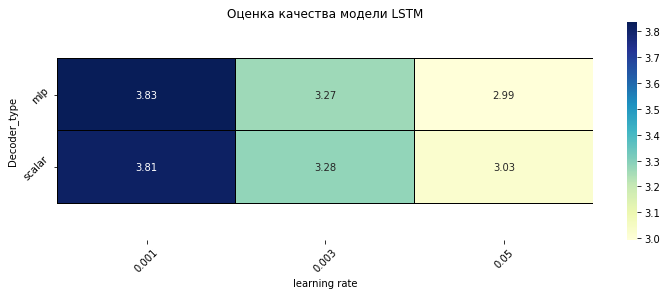

In [ ]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)&
                     (results.RNN_Type=='LSTM')]

fine_table(pd.pivot_table(  temp_table,
                            values  = 'Loss',
                            columns = 'learn_rate',
                            index   = 'Decoder',
                            aggfunc = 'max'
                         ), 
           title = 'Оценка качества модели LSTM', 
           x_l='learning rate', y_l = 'Decoder_type')  

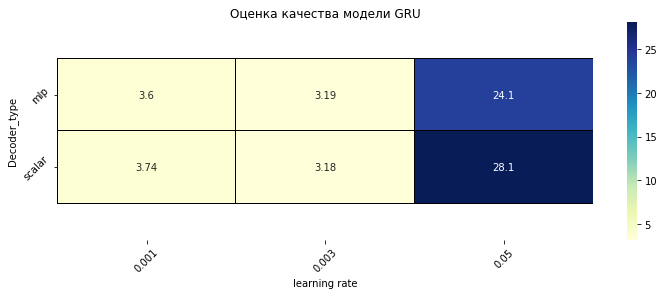

In [ ]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)&
                     (results.RNN_Type=='GRU')]

fine_table(pd.pivot_table(  temp_table,
                            values  = 'Loss',
                            columns = 'learn_rate',
                            index   = 'Decoder',
                            aggfunc = 'max'
                         ), 
           title = 'Оценка качества модели GRU', 
           x_l='learning rate', y_l = 'Decoder_type')

In [20]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)]

fine_table(pd.pivot_table(  temp_table,
                            values  = 'Loss',
                            columns = 'Decoder',
                            index   = ['RNN_Type', 'learn_rate'],
                            aggfunc = 'max'
                         ), 
           title = 'Оценка качества модели от типа декодера Attention', 
           x_l='Decoder_type', y_l = 'RNN / learning rate')

In [21]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)]

fine_table(pd.pivot_table(  temp_table,
                            values  = 'Loss',
                            columns = 'Decoder',
                            index   = ['RNN_Type', 'learn_rate'],
                            aggfunc = 'max'
                         ), 
           title = 'Оценка качества модели от типа декодера Attention', 
           x_l='Decoder_type', y_l = 'RNN / learning rate')

In [39]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)]
temp_table.head(1)

,learn_rate,Max_length,RNN_Type,Decoder,Loss
2,0.05,20,RNN,mlp,24.655075


In [32]:
fine_table(pd.pivot_table(  temp_table,
                            values  = 'Loss',
                            columns = 'Decoder',
                            index   = ['RNN_Type', 'learn_rate'],
                            aggfunc = 'max'
                         ), 
           title = 'Оценка качества модели от типа декодера Attention', 
           x_l='Decoder_type', y_l = 'RNN / learning rate')

In [38]:
pp = pd.pivot_table(  temp_table,
                            values  = 'Loss',
                            columns = 'Decoder',
                            index   = ['RNN_Type', 'learn_rate'],
                            aggfunc = 'max'
                         )
pp

Decoder                    mlp     scalar
RNN_Type learn_rate                      
GRU      0.001        3.600392   3.739083
         0.003        3.185217   3.181635
         0.050       24.058059  28.091668
LSTM     0.001        3.834810   3.813181
         0.003        3.265885   3.280422
         0.050        2.994014   3.025424
RNN      0.050       24.655075  17.377365